<a href="https://colab.research.google.com/github/yeon524/IDS/blob/main/IDS_Team4_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os

base_url = "https://zenodo.org/record/8145223/files"

files = [
    "preprocessed-IMU-with-operation-labels.zip",
    "U0101.zip","U0102.zip","U0103.zip","U0104.zip","U0105.zip",
    "U0106.zip","U0107.zip","U0108.zip","U0109.zip","U0110.zip","U0111.zip",
    "U0201.zip","U0202.zip","U0203.zip","U0204.zip","U0205.zip",
    "U0206.zip","U0207.zip","U0208.zip","U0209.zip","U0210.zip"
]

os.makedirs("openpack_raw", exist_ok=True)

for f in files:
    url = f"{base_url}/{f}?download=1"
    save_path = f"openpack_raw/{f}"

    print(f"⬇️ Downloading {f} ...")
    !wget -q "{url}" -O "{save_path}"
    print(f"   ✔ Saved to {save_path}")

print("\n All files downloaded successfully!")

os.makedirs("openpack", exist_ok=True)

for f in files:
    zip_path = f"openpack_raw/{f}"
    if f.endswith(".zip"):
        extract_dir = f"openpack/{f.replace('.zip','')}"
        print(f"📦 Extracting {f} ...")
        !unzip -q "{zip_path}" -d "{extract_dir}"

print("\n All files extracted successfully!")

⬇️ Downloading preprocessed-IMU-with-operation-labels.zip ...
^C
   ✔ Saved to openpack_raw/preprocessed-IMU-with-operation-labels.zip
⬇️ Downloading U0101.zip ...
^C
   ✔ Saved to openpack_raw/U0101.zip
⬇️ Downloading U0102.zip ...
^C
   ✔ Saved to openpack_raw/U0102.zip
⬇️ Downloading U0103.zip ...
^C
   ✔ Saved to openpack_raw/U0103.zip
⬇️ Downloading U0104.zip ...
^C
   ✔ Saved to openpack_raw/U0104.zip
⬇️ Downloading U0105.zip ...
^C
   ✔ Saved to openpack_raw/U0105.zip
⬇️ Downloading U0106.zip ...
^C
   ✔ Saved to openpack_raw/U0106.zip
⬇️ Downloading U0107.zip ...
^C
   ✔ Saved to openpack_raw/U0107.zip
⬇️ Downloading U0108.zip ...
^C
   ✔ Saved to openpack_raw/U0108.zip
⬇️ Downloading U0109.zip ...
^C
   ✔ Saved to openpack_raw/U0109.zip
⬇️ Downloading U0110.zip ...
^C
   ✔ Saved to openpack_raw/U0110.zip
⬇️ Downloading U0111.zip ...


In [ ]:
!rm -rf openpack-dataset
!git clone https://github.com/yeon524/openpack-dataset.git -q

import os, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

os.chdir("/content/openpack-dataset/docs/data-collection")

rows = []
with open("sessions.md", "r", encoding="utf-8") as f:
    for line in f:

        if "|" not in line:
            continue
        if "Subject" in line or "---" in line:
            continue

        parts = [c.strip() for c in line.split("|") if c.strip()]
        if not parts:
            continue


        if not parts[0].startswith("U0"):
            continue


        if len(parts) >= 7:
            rows.append(parts[:7])

df = pd.DataFrame(rows, columns=["Subject","Session","Scenario",
                                 "Duration","Periods","Start","End"])

print("Raw dataframe shape:", df.shape)
display(df.head())

In [4]:
import os, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob

sessions_md_path = "/content/openpack-dataset/docs/data-collection/sessions.md"

rows = []
with open(sessions_md_path, "r", encoding="utf-8") as f:
    for line in f:
        if "|" not in line:
            continue
        if "Subject" in line or "---" in line:
            continue

        parts = [c.strip() for c in line.split("|") if c.strip()]
        if not parts:
            continue
        if not parts[0].startswith("U0"):
            continue

        rows.append(parts[:7])

sessions_df = pd.DataFrame(
    rows,
    columns=["Subject", "Session", "Scenario", "Duration", "Periods", "Start", "End"]
)[["Subject","Session","Scenario"]]

sessions_df.head()

,Subject,Session,Scenario
0,U0101,S0100,S1
1,U0101,S0200,S1
2,U0101,S0300,S1
3,U0101,S0400,S1
4,U0101,S0500,S1


In [5]:
BASE = "/content/openpack"

all_rows = []

# Collect all action annotation CSV files
action_files = glob(os.path.join(BASE, "U0*", "annotation", "openpack-actions", "S*.csv"))
print("Number of CSV files found:", len(action_files))

for fpath in action_files:

    parts = fpath.split(os.sep)
    subject_id = parts[-4]
    session_id = os.path.splitext(parts[-1])[0]

    df = pd.read_csv(fpath)


    if not {"start","end"}.issubset(df.columns):
        continue

    df["Subject"] = subject_id
    df["Session"] = session_id

    df["start_dt"] = pd.to_datetime(df["start"], errors="coerce")
    df["end_dt"]   = pd.to_datetime(df["end"], errors="coerce")

    df["duration_sec"] = (df["end_dt"] - df["start_dt"]).dt.total_seconds()

    all_rows.append(df[["Subject","Session","duration_sec"]])

if not all_rows:
    raise ValueError("❌ No valid S*.csv files were loaded. Please check the directory path.")

raw = pd.concat(all_rows, ignore_index=True)
print("Total number of rows:", len(raw))
print(raw.head())

Number of CSV files found: 104
Total number of rows: 53760
  Subject Session  duration_sec
0   U0110   S0500         1.785
1   U0110   S0500         2.320
2   U0110   S0500         1.222
3   U0110   S0500         2.389
4   U0110   S0500         2.174


In [6]:
raw = raw.merge(sessions_df, on=["Subject","Session"], how="left")

session_subject_stats = (
    raw.groupby(["Scenario","Subject","Session"])
       .agg(
           mean_period=("duration_sec","mean"),
           n_periods=("duration_sec","count")
       )
       .reset_index()
)

session_consistency = (
    session_subject_stats.groupby(["Scenario","Session"])
        .agg(
            n_subjects=("Subject","nunique"),
            mean_period=("mean_period","mean"),
            std_period=("mean_period","std"),
            mad_period=("mean_period", lambda x: np.mean(np.abs(x - x.mean())))
        )
        .reset_index()
)

session_consistency = session_consistency[session_consistency["n_subjects"] >= 2]

print("=== Session-level consistency ===")
print(session_consistency)

=== Session-level consistency ===
   Scenario Session  n_subjects  mean_period  std_period  mad_period
4       ALL   S0100           3     2.184036    0.307805    0.232769
5       ALL   S0200           3     2.421669    0.820811    0.619845
7       ALL   S0400           5     2.426479    0.172318    0.149187
8       ALL   S0500           3     1.977543    0.398699    0.293455
9        S1   S0100          11     2.884942    0.424456    0.337044
10       S1   S0200          11     2.485442    0.489918    0.304135
11       S1   S0300          11     2.396099    0.184511    0.129215
12       S1   S0400          11     2.356338    0.199382    0.151427
13       S1   S0500          10     2.308590    0.351816    0.244123
14       S2   S0100          10     2.366732    0.238464    0.200066
15       S2   S0200           9     2.053194    0.186718    0.160747
18       S3   S0300          10     2.209528    0.261577    0.212920
19       S3   S0400           9     2.143570    0.205854    0.159590


In [8]:
scenario_mean = (
    session_subject_stats.groupby("Scenario")["mean_period"]
    .mean()
    .rename("scenario_mean_period")
    .reset_index()
)

dev_df = session_subject_stats.merge(scenario_mean, on="Scenario", how="left")
dev_df["deviation"] = dev_df["mean_period"] - dev_df["scenario_mean_period"]
dev_df.head()

,Scenario,Subject,Session,mean_period,n_periods,scenario_mean_period,deviation
0,"1,2,3,4,5,6,7,8,9,10,",U0103,S0100,2.823489,266,2.670586,0.152903
1,"1,2,3,4,5,6,7,8,9,10,",U0108,S0400,2.517683,543,2.670586,-0.152903
2,"10,11,12,13,14,15,16,17,18,19,20,",U0107,S0300,2.333562,532,2.333562,0.000000
3,"17,18,19,20,",U0109,S0100,3.024056,549,3.024056,0.000000
4,ALL,U0101,S0100,2.533189,533,2.283638,0.249551


In [7]:
subject_consistency = (
    session_subject_stats.groupby("Subject")["mean_period"]
    .agg(
        subject_mean = "mean",
        subject_std = "std",
        subject_mad = lambda x: np.mean(np.abs(x - x.mean()))
    )
    .reset_index()
)
subject_consistency.head()

,Subject,subject_mean,subject_std,subject_mad
0,U0101,2.283992,0.202844,0.174833
1,U0102,2.843907,0.368323,0.306418
2,U0103,2.438509,0.260986,0.202975
3,U0104,3.033715,0.444047,0.395559
4,U0105,2.494739,0.164502,0.140956


**Objective 1**

In [9]:
subj_scenario_consistency = (
    session_subject_stats.groupby(["Subject", "Scenario"])["mean_period"]
    .agg(std_period="std", mean_period="mean")
    .reset_index()
)

In [10]:
subj_scenario_consistency = (
    session_subject_stats
    .groupby(["Subject", "Scenario"])["mean_period"]
    .agg(
        std_period="std",
        mean_period="mean"
    )
    .reset_index()
)

In [11]:
subj_scenario_consistency = subj_scenario_consistency[
    subj_scenario_consistency["Scenario"].isin(["S1", "S2", "S3", "S4"])
]
scenario_order = ["S1", "S2", "S3", "S4"]

In [12]:
raw_ops = raw.copy()

raw_ops Scenario counts:
Scenario
S1                                   27909
S2                                   10621
S3                                   10182
ALL                                   7387
S4                                    5048
1,2,3,4,5,6,7,8,9,10,                  810
17,18,19,20,                           550
10,11,12,13,14,15,16,17,18,19,20,      533
Name: count, dtype: int64

Unique Scenario values:
['1,2,3,4,5,6,7,8,9,10,', '10,11,12,13,14,15,16,17,18,19,20,', '17,18,19,20,', 'ALL', 'S1', 'S2', 'S3', 'S4']

subj_scenario_consistency Scenario counts:
Scenario
NaN    12
S1     11
S2     10
S3     10
S4     10
Name: count, dtype: int64


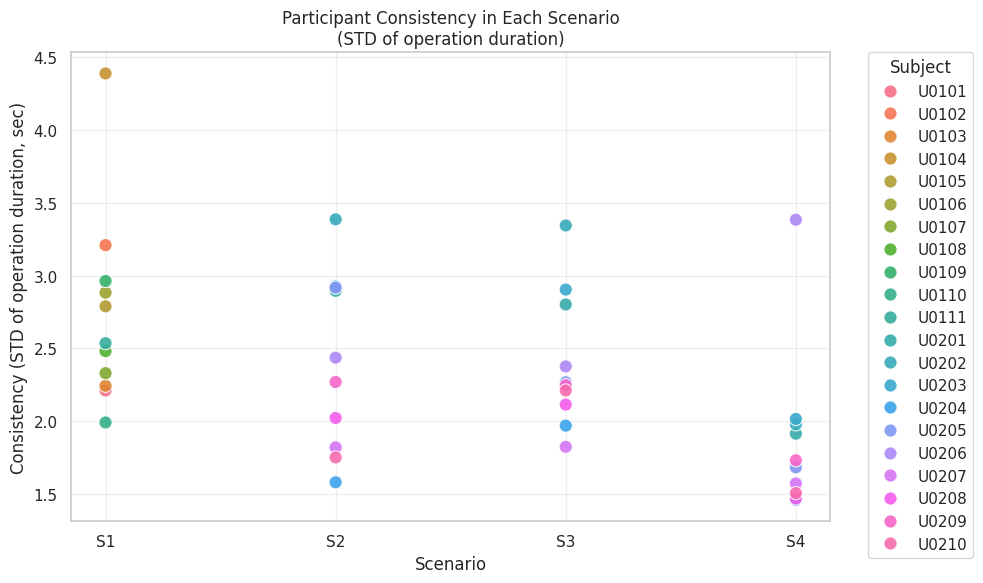

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

print("raw_ops Scenario counts:")
print(raw_ops["Scenario"].value_counts(dropna=False))

print("\nUnique Scenario values:")
print(sorted(raw_ops["Scenario"].dropna().unique()))

df = raw_ops.copy()
df["Scenario"] = df["Scenario"].astype(str).str.strip()
df["Scenario"] = df["Scenario"].replace({"S04": "S4", "S01": "S1", "S02": "S2", "S03": "S3"})

subj_scenario_consistency = (
    df.groupby(["Subject", "Scenario"])["duration_sec"]
      .agg(
          n=("count"),
          mean_period=("mean"),
          std_period=(lambda x: x.std(ddof=0))
      )
      .reset_index()
)

order = ["S1", "S2", "S3", "S4"]
subj_scenario_consistency["Scenario"] = pd.Categorical(
    subj_scenario_consistency["Scenario"],
    categories=order,
    ordered=True
)

subj_scenario_consistency["std_period"] = subj_scenario_consistency["std_period"].fillna(0)

print("\nsubj_scenario_consistency Scenario counts:")
print(subj_scenario_consistency["Scenario"].value_counts(dropna=False))

plt.figure(figsize=(10, 6))

sns.scatterplot(
    data=subj_scenario_consistency,
    x="Scenario",
    y="std_period",
    hue="Subject",
    s=90,
    alpha=0.9
)

plt.title("Participant Consistency in Each Scenario\n(STD of operation duration)")
plt.xlabel("Scenario")
plt.ylabel("Consistency (STD of operation duration, sec)")
plt.grid(alpha=0.3)
plt.xticks(order)

plt.legend(
    title="Subject",
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
    borderaxespad=0
)

plt.tight_layout()
plt.show()


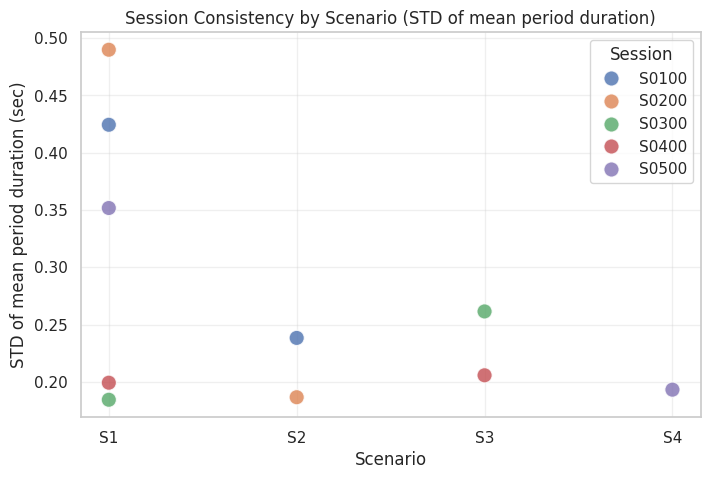

In [14]:
plot_df = session_consistency[session_consistency["Scenario"].isin(["S1","S2","S3","S4"])]

plt.figure(figsize=(8,5))
sns.scatterplot(
    data=plot_df,
    x="Scenario",
    y="std_period",
    hue="Session",
    s=120,
    alpha=0.8
)

plt.title("Session Consistency by Scenario (STD of mean period duration)")
plt.xlabel("Scenario")
plt.ylabel("STD of mean period duration (sec)")
plt.grid(True, alpha=0.3)
plt.show()

**Objective 2**

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(
    style="whitegrid",
    font_scale=1.1,
    rc={
        "axes.edgecolor": "#666666",
        "grid.color": "#DDDDDD",
        "axes.labelweight": "bold",
        "axes.titleweight": "bold",
        "axes.titlepad": 12,
        "figure.dpi": 120,
        "font.family": "sans-serif",
    }
)

pretty_palette = sns.color_palette("pastel")
sns.set_palette(pretty_palette)

In [16]:
def plot_meta(meta, title_suffix):

    # =======================
    # A) Age vs Duration
    # =======================
    plt.figure(figsize=(7,5))
    sns.regplot(
        data=meta,
        x="Age_num",
        y="mean_duration",
        scatter_kws={"s":90, "alpha":0.8, "edgecolor":"#444"},
        line_kws={"color":"#FF9999", "linewidth":2},
    )
    plt.title(f"Age vs Mean Task Duration\n({title_suffix})", fontsize=14)
    plt.xlabel("Age (years)")
    plt.ylabel("Mean Task Duration (sec)")
    plt.tight_layout()
    plt.show()


    # =======================
    # B) Experience vs Duration
    # =======================
    plt.figure(figsize=(7,5))
    sns.regplot(
        data=meta,
        x="Exp_months",
        y="mean_duration",
        scatter_kws={"s":90, "alpha":0.8, "edgecolor":"#444"},
        line_kws={"color":"#99CCFF", "linewidth":2},
    )
    plt.title(f"Experience vs Mean Task Duration\n({title_suffix})", fontsize=14)
    plt.xlabel("Experience (months)")
    plt.ylabel("Mean Task Duration (sec)")
    plt.tight_layout()
    plt.show()


    # =======================
    # C) Sex vs Duration
    # =======================
    plt.figure(figsize=(6,5))
    sns.boxplot(
        data=meta,
        x="Sex",
        y="mean_duration",
        linewidth=1.5,
        width=0.5,
        palette="pastel"
    )
    sns.stripplot(
        data=meta,
        x="Sex",
        y="mean_duration",
        color="#555",
        alpha=0.7,
        size=7
    )
    plt.title(f"Mean Task Duration by Sex\n({title_suffix})", fontsize=14)
    plt.xlabel("Sex")
    plt.ylabel("Mean Task Duration (sec)")
    plt.tight_layout()
    plt.show()


    # =======================
    # D) Dominant Hand vs Duration
    # =======================
    plt.figure(figsize=(6,5))
    sns.boxplot(
        data=meta,
        x="DominantHand",
        y="mean_duration",
        width=0.5,
        linewidth=1.5,
        palette="pastel"
    )
    sns.stripplot(
        data=meta,
        x="DominantHand",
        y="mean_duration",
        color="#555",
        alpha=0.7,
        size=7
    )
    plt.title(f"Mean Task Duration by Dominant Hand\n({title_suffix})", fontsize=14)
    plt.xlabel("Dominant Hand")
    plt.ylabel("Mean Task Duration (sec)")
    plt.tight_layout()
    plt.show()

=== subjects_df (with Age_num, Exp_months) ===
  Subject Sex  Age DominantHand Experience  Note  Age_num  Exp_months
0   U0101   F    -        Right          -  None      NaN           0
1   U0102   F    -        Right          -  None      NaN           0
2   U0103   F  50s        Right    6 Month  None     50.0           6
3   U0104   F  50s        Right    1 Month  None     50.0           1
4   U0105   F  30s        Right     4 Year  None     30.0          48

===== Scenario S1 =====


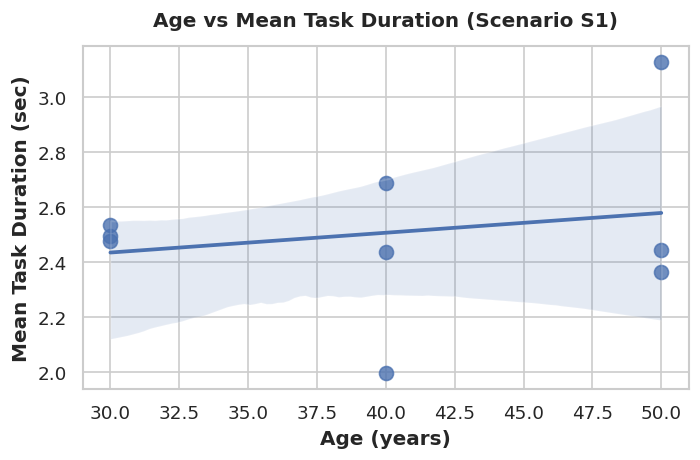

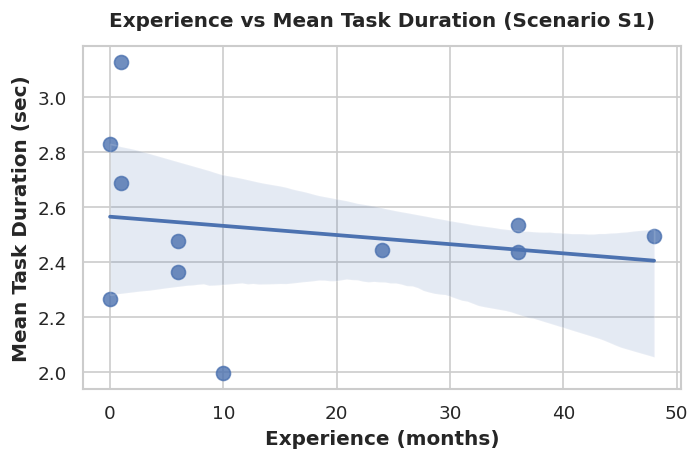

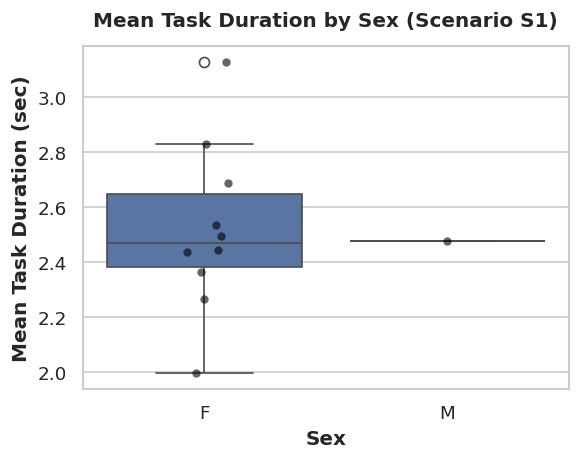

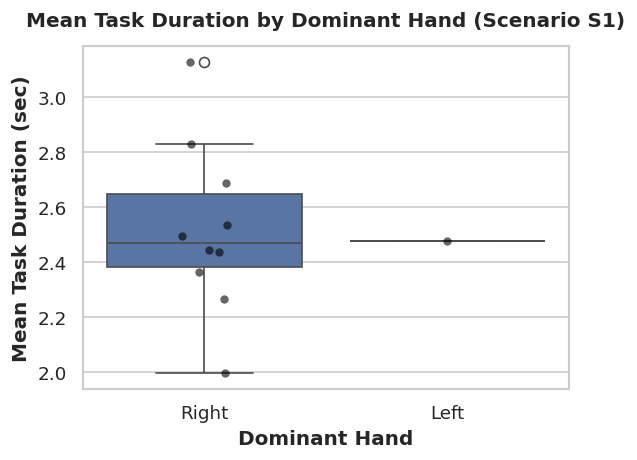


===== Scenarios S2–S4 Combined =====


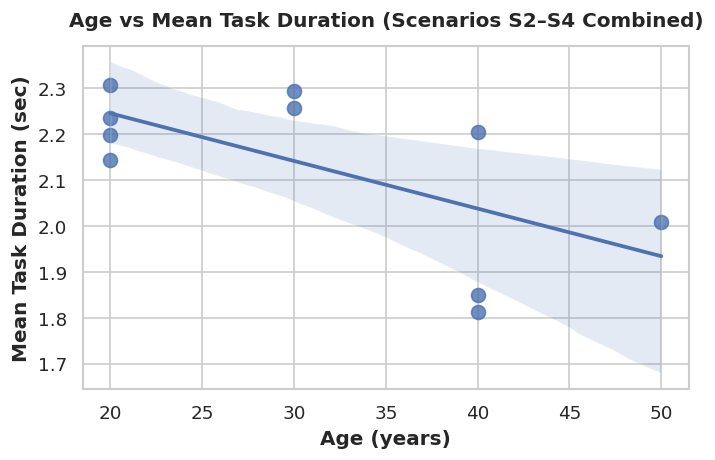

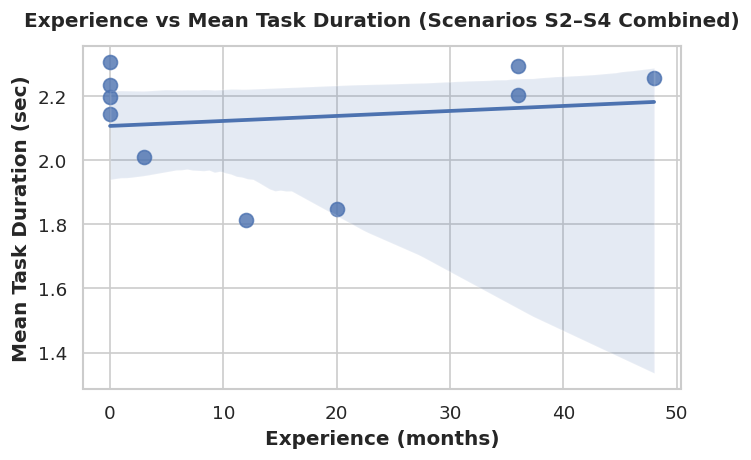

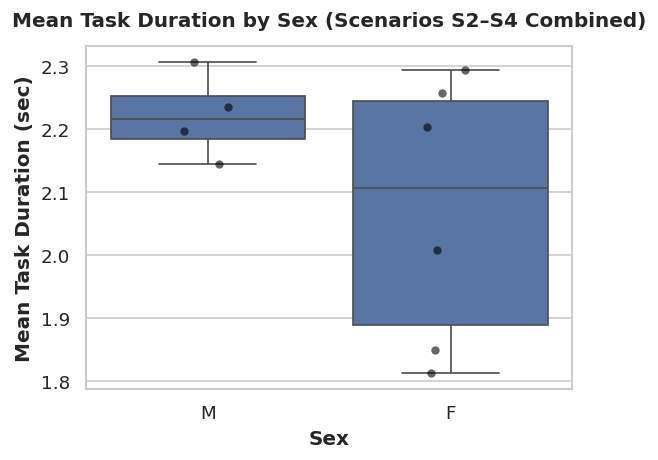

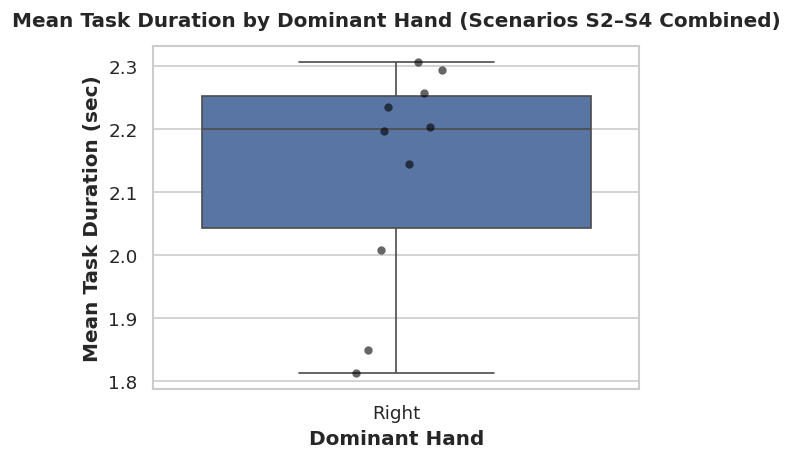


===== All Scenarios (S1–S4) Combined =====


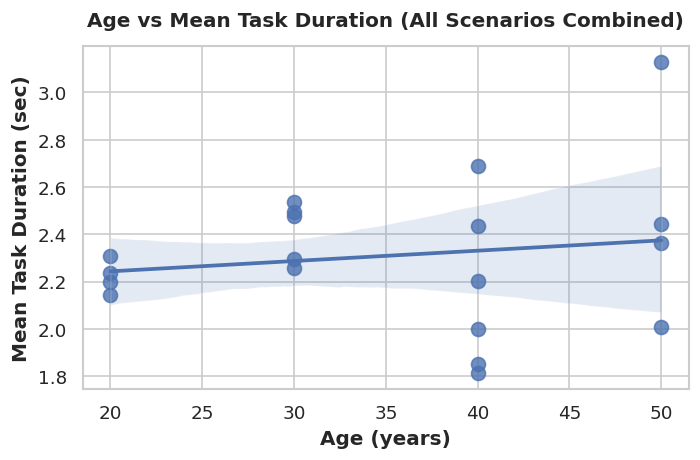

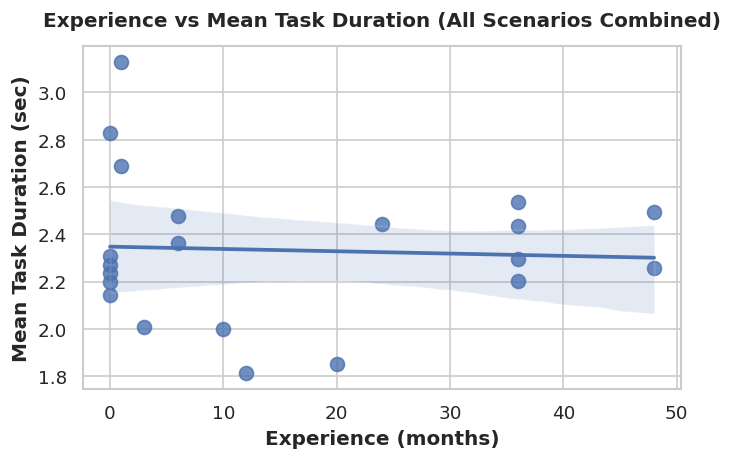

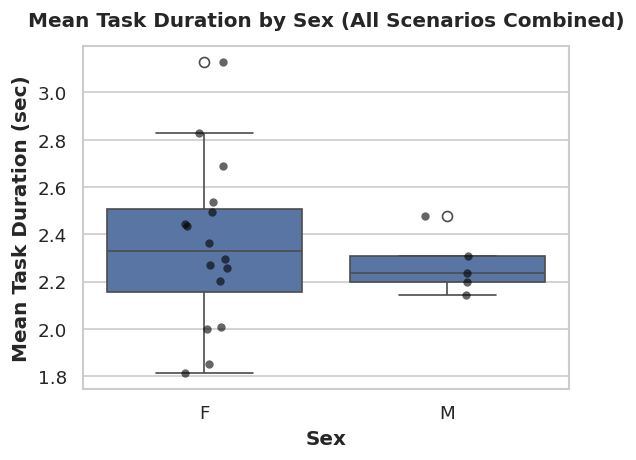

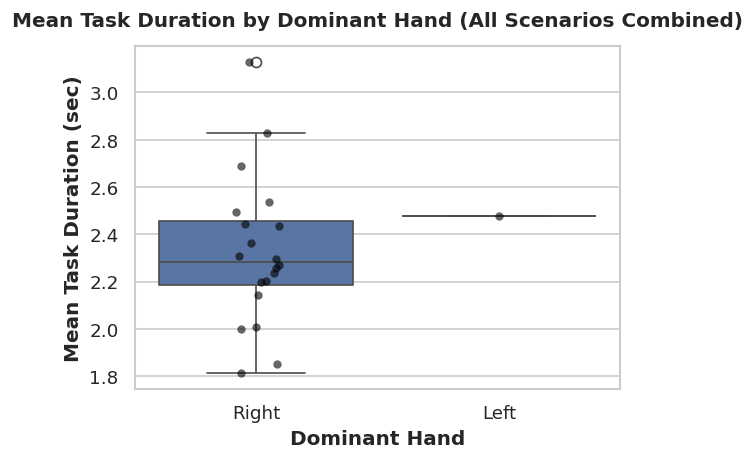

In [17]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

subjects_md_path = "/content/openpack-dataset/docs/data-collection/subjects.md"

rows = []
with open(subjects_md_path, "r", encoding="utf-8") as f:
    for line in f:
        line = line.strip()
        if "|" not in line:
            continue
        if "Subject" in line or "---" in line:
            continue

        parts = [c.strip() for c in line.split("|") if c.strip()]
        if not parts:
            continue
        if not parts[0].startswith("U0"):
            continue

        # Subject, Sex, Age, Dominant Hand, Experience, Note (앞에서 봤던 구조)
        rows.append(parts[:6])

subjects_df = pd.DataFrame(
    rows,
    columns=["Subject", "Sex", "Age", "DominantHand", "Experience", "Note"]
)

# -----------------------------
# Age: "20s" → 20
# -----------------------------
def parse_age(age_str):
    if pd.isna(age_str):
        return np.nan
    s = str(age_str).strip()
    if s in ["", "-"]:
        return np.nan
    m = re.match(r"(\d+)", s)
    if m:
        return int(m.group(1))
    return np.nan

subjects_df["Age_num"] = subjects_df["Age"].apply(parse_age)

# -----------------------------
# Experience: "6 Month", "2 Years", "12m", "3y" → months
# -----------------------------
def parse_experience(x):
    if pd.isna(x):
        return np.nan

    s = str(x).strip().lower()
    if s in ["", "-", "none"]:
        return 0

    m1 = re.match(r"(\d+)\s*(month|months|year|years)", s)
    if m1:
        num = int(m1.group(1))
        unit = m1.group(2)
        if "year" in unit:
            return num * 12
        else:
            return num

    m2 = re.match(r"(\d+)\s*(m|y)", s)
    if m2:
        num = int(m2.group(1))
        unit = m2.group(2)
        if unit == "y":
            return num * 12
        else:
            return num

    if s.isdigit():
        return int(s)

    return np.nan

subjects_df["Exp_months"] = subjects_df["Experience"].apply(parse_experience)

print("=== subjects_df (with Age_num, Exp_months) ===")
print(subjects_df.head())


# ============================================
# 1. Function to compute participant-level
#    mean duration by scenario group
# ============================================
def compute_meta_for_scenarios(scenario_list, label=""):
    """
    scenario_list: ["S1"], ["S2","S3","S4"], ["S1","S2","S3","S4"] 등
    label: 그래프 title에 붙일 텍스트
    """
    sub = raw[raw["Scenario"].isin(scenario_list)].copy()

    if sub.empty:
        print(f"No data for scenarios: {scenario_list}")
        return None

    perf = (
        sub.groupby("Subject")["duration_sec"]
           .agg(mean_duration="mean", std_duration="std", n_ops="count")
           .reset_index()
    )

    meta = perf.merge(subjects_df, on="Subject", how="left")
    meta["scenario_label"] = label
    return meta


# ============================================
# 2. Create meta datasets
#    (1) S1 only
#    (2) S2–S4 combined
#    (3) S1–S4 combined
# ============================================
meta_s1   = compute_meta_for_scenarios(["S1"], label="Scenario S1")
meta_s234 = compute_meta_for_scenarios(["S2", "S3", "S4"], label="Scenarios S2–S4")
meta_all  = compute_meta_for_scenarios(["S1", "S2", "S3", "S4"], label="All Scenarios")

# ============================================
# 3. Common plotting function
# ============================================
def plot_meta(meta, title_suffix):
    if meta is None or meta.empty:
        print(f"[WARN] No data for {title_suffix}")
        return

    # A. Age vs Duration
    plt.figure(figsize=(6,4))
    sns.regplot(
        data=meta,
        x="Age_num",
        y="mean_duration",
        scatter_kws={"s":70, "alpha":0.8}
    )
    plt.title(f"Age vs Mean Task Duration ({title_suffix})")
    plt.xlabel("Age (years)")
    plt.ylabel("Mean Task Duration (sec)")
    plt.tight_layout()
    plt.show()

    # B. Experience vs Duration
    plt.figure(figsize=(6,4))
    sns.regplot(
        data=meta,
        x="Exp_months",
        y="mean_duration",
        scatter_kws={"s":70, "alpha":0.8}
    )
    plt.title(f"Experience vs Mean Task Duration ({title_suffix})")
    plt.xlabel("Experience (months)")
    plt.ylabel("Mean Task Duration (sec)")
    plt.tight_layout()
    plt.show()

    # C. Sex vs Duration
    plt.figure(figsize=(5,4))
    sns.boxplot(data=meta, x="Sex", y="mean_duration")
    sns.stripplot(data=meta, x="Sex", y="mean_duration",
                  color="black", alpha=0.6)
    plt.title(f"Mean Task Duration by Sex ({title_suffix})")
    plt.xlabel("Sex")
    plt.ylabel("Mean Task Duration (sec)")
    plt.tight_layout()
    plt.show()

    # D. Dominant Hand vs Duration
    plt.figure(figsize=(5,4))
    sns.boxplot(data=meta, x="DominantHand", y="mean_duration")
    sns.stripplot(data=meta, x="DominantHand", y="mean_duration",
                  color="black", alpha=0.6)
    plt.title(f"Mean Task Duration by Dominant Hand ({title_suffix})")
    plt.xlabel("Dominant Hand")
    plt.ylabel("Mean Task Duration (sec)")
    plt.tight_layout()
    plt.show()


# ============================================
# 4. Plot all three versions
# ============================================
print("\n===== Scenario S1 =====")
plot_meta(meta_s1, "Scenario S1")

print("\n===== Scenarios S2–S4 Combined =====")
plot_meta(meta_s234, "Scenarios S2–S4 Combined")

print("\n===== All Scenarios (S1–S4) Combined =====")
plot_meta(meta_all, "All Scenarios Combined")

In [18]:
def factor_rank(meta, title=""):
    cols = ["Age_num", "Exp_months"]

    meta = meta.copy()
    meta["Sex_num"] = meta["Sex"].map({"M":1, "F":0})
    meta["Hand_num"] = meta["DominantHand"].map({"Right":1, "Left":0})

    cols += ["Sex_num", "Hand_num"]

    corr_list = []
    for c in cols:
        corr = meta[[c, "mean_duration"]].corr().iloc[0,1]
        corr_list.append((c, corr, abs(corr)))

    df_rank = pd.DataFrame(corr_list, columns=["Factor", "Correlation", "AbsCorrelation"])
    df_rank = df_rank.sort_values("AbsCorrelation", ascending=False)

    print(f"\n===== Factor Influence Ranking ({title}) =====")
    print(df_rank)

    plt.figure(figsize=(7,5))
    sns.barplot(
        data=df_rank,
        x="AbsCorrelation",
        y="Factor",
        palette="pastel"
    )
    plt.title(f"Influence Ranking (Correlation)\n{title}")
    plt.xlabel("Absolute Correlation with Duration")
    plt.ylabel("Factor")
    plt.tight_layout()
    plt.show()

    return df_rank


===== Factor Influence Ranking (All Scenarios Combined) =====
       Factor  Correlation  AbsCorrelation
0     Age_num     0.153949        0.153949
2     Sex_num    -0.110856        0.110856
3    Hand_num    -0.106444        0.106444
1  Exp_months    -0.054795        0.054795


/tmp/ipython-input-558848486.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


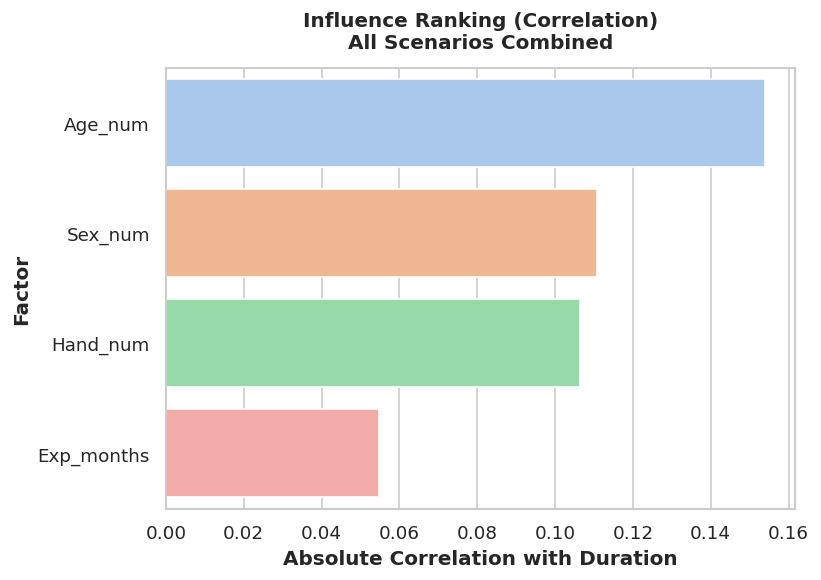


===== Factor Influence Ranking (Scenario S1) =====
       Factor  Correlation  AbsCorrelation
0     Age_num     0.209159        0.209159
1  Exp_months    -0.198090        0.198090
2     Sex_num    -0.043245        0.043245
3    Hand_num     0.043245        0.043245


/tmp/ipython-input-558848486.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


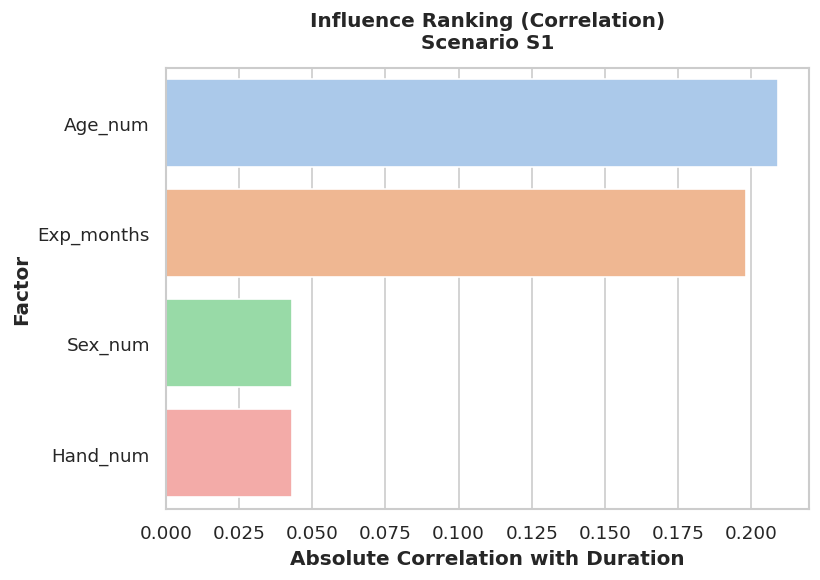


===== Factor Influence Ranking (Scenarios S2–S4 Combined) =====
       Factor  Correlation  AbsCorrelation
0     Age_num    -0.636356        0.636356
2     Sex_num     0.431031        0.431031
1  Exp_months     0.159895        0.159895
3    Hand_num          NaN             NaN


/tmp/ipython-input-558848486.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


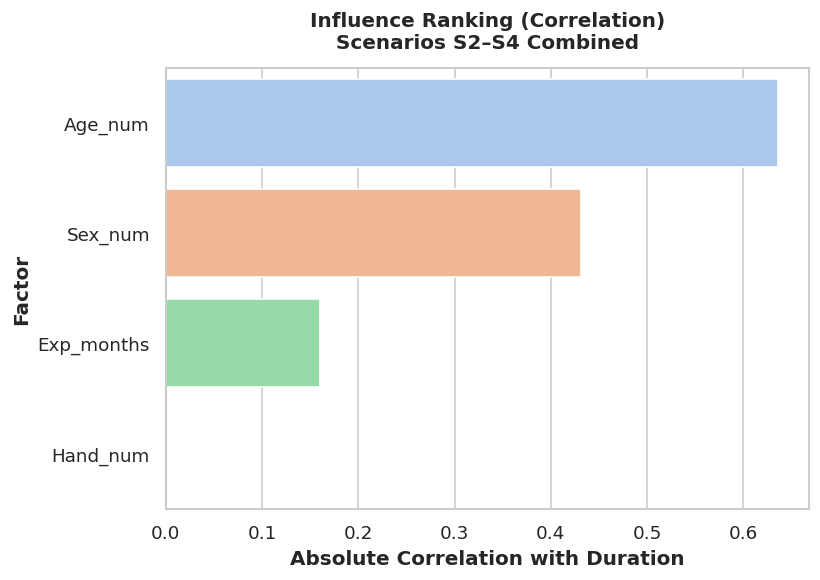

In [19]:
rank_all = factor_rank(meta_all, "All Scenarios Combined")

rank_s1 = factor_rank(meta_s1, "Scenario S1")

rank_s234 = factor_rank(meta_s234, "Scenarios S2–S4 Combined")

**Objective 3**

In [20]:
import os
import pandas as pd
from glob import glob

BASE = "/content/openpack"

all_rows = []

action_files = glob(os.path.join(BASE, "U0*", "annotation", "openpack-actions", "S*.csv"))
print("Found action csv files:", len(action_files))

for fpath in action_files:
    parts = fpath.split(os.sep)
    subject_id = parts[-4]
    session_id = os.path.splitext(parts[-1])[0]

    df = pd.read_csv(fpath)

    if not {"start","end"}.issubset(df.columns):
        continue

    op_col = None
    for cand in ["operation", "op", "op_id", "label"]:
        if cand in df.columns:
            op_col = cand
            break
    if op_col is None:
        continue

    df["Subject"] = subject_id
    df["Session"] = session_id
    df["operation_name"] = df[op_col].astype(str)

    df["start_dt"] = pd.to_datetime(df["start"], errors="coerce")
    df["end_dt"]   = pd.to_datetime(df["end"], errors="coerce")
    df["duration_sec"] = (df["end_dt"] - df["start_dt"]).dt.total_seconds()

    df = df.dropna(subset=["duration_sec"])
    df = df[df["duration_sec"] > 0]

    all_rows.append(df[["Subject","Session","operation_name","duration_sec"]])

if not all_rows:
    raise ValueError("❌ No valid action rows collected. Check csv structure/columns.")

raw_ops = pd.concat(all_rows, ignore_index=True)
print("Total rows:", len(raw_ops))
print(raw_ops.head())

Found action csv files: 104
Total rows: 53081
  Subject Session       operation_name  duration_sec
0   U0110   S0500              Picking         1.785
1   U0110   S0500              Picking         2.320
2   U0110   S0500  Relocate Item Label         1.222
3   U0110   S0500  Relocate Item Label         2.389
4   U0110   S0500         Assemble Box         2.174


In [ ]:
import pandas as pd
import re
import os

session_rows = []

def find_sessions_md():
    path1 = "/content/openpack-dataset/docs/data-collection/sessions.md"
    if os.path.exists(path1):
        return path1

    cur = os.getcwd()
    for _ in range(6):
        candidate = os.path.join(cur, "openpack-dataset", "docs", "data-collection", "sessions.md")
        if os.path.exists(candidate):
            return candidate
        cur = os.path.dirname(cur)

    raise FileNotFoundError("❌ sessions.md not found. Check openpack-dataset path.")

sessions_md_path = find_sessions_md()
print("Reading file:", sessions_md_path)

with open(sessions_md_path, "r", encoding="utf-8") as f:
    for line in f:

        if "|" not in line:
            continue
        if "Subject" in line or "---" in line:
            continue

        parts = [c.strip() for c in line.split("|") if c.strip()]
        if not parts:
            continue

        if not parts[0].startswith("U0"):
            continue

        subject, session_id, scenario = parts[0], parts[1], parts[2]
        session_rows.append([subject, session_id, scenario])

sessions_df = pd.DataFrame(
    session_rows,
    columns=["Subject", "Session", "Scenario"]
)

print("=== sessions_df head ===")
print(sessions_df.head())
print("rows:", len(sessions_df))

In [ ]:
print(sessions_df["Scenario"].value_counts(dropna=False).head(20))
print("unique:", sorted(sessions_df["Scenario"].dropna().unique()))


In [ ]:
raw_ops = raw_ops.merge(sessions_df, on=["Subject", "Session"], how="left")
print("\n=== raw_ops with Scenario head ===")
print(raw_ops.head())

In [ ]:
raw = raw.drop(columns=[c for c in ["Scenario", "Scenario_x", "Scenario_y"] if c in raw.columns])

sessions_key = (
    sessions_df[["Subject","Session","Scenario"]]
    .drop_duplicates(subset=["Subject","Session"])
)

raw = raw.merge(sessions_key, on=["Subject","Session"], how="left")

session_subject_stats = (
    raw.groupby(["Scenario","Subject","Session"])
       .agg(
           mean_period=("duration_sec","mean"),
           n_periods=("duration_sec","count")
       )
       .reset_index()
)

session_consistency = (
    session_subject_stats.groupby(["Scenario","Session"])
        .agg(
            n_subjects=("Subject","nunique"),
            mean_period=("mean_period","mean"),
            std_period=("mean_period","std"),
            mad_period=("mean_period", lambda x: np.mean(np.abs(x - x.mean())))
        )
        .reset_index()
)

session_consistency = session_consistency[session_consistency["n_subjects"] >= 2]

print("=== Session-level consistency ===")
print(session_consistency)


In [21]:
raw_ops = raw_ops.drop(columns=["Scenario_x", "Scenario_y"], errors="ignore")

raw_ops = raw_ops.drop(columns=["Scenario"], errors="ignore")

sessions_clean = sessions_df.copy()
sessions_clean["Scenario"] = sessions_clean["Scenario"].astype(str).str.strip()
sessions_clean = sessions_clean[sessions_clean["Scenario"].isin(["S1","S2","S3","S4"])]

raw_ops = raw_ops.merge(
    sessions_clean[["Subject","Session","Scenario"]].drop_duplicates(),
    on=["Subject","Session"],
    how="left"
)

print(raw_ops["Scenario"].value_counts(dropna=False).head(10))

Scenario
S1    27295
S2    10586
S3    10160
S4     5040
Name: count, dtype: int64


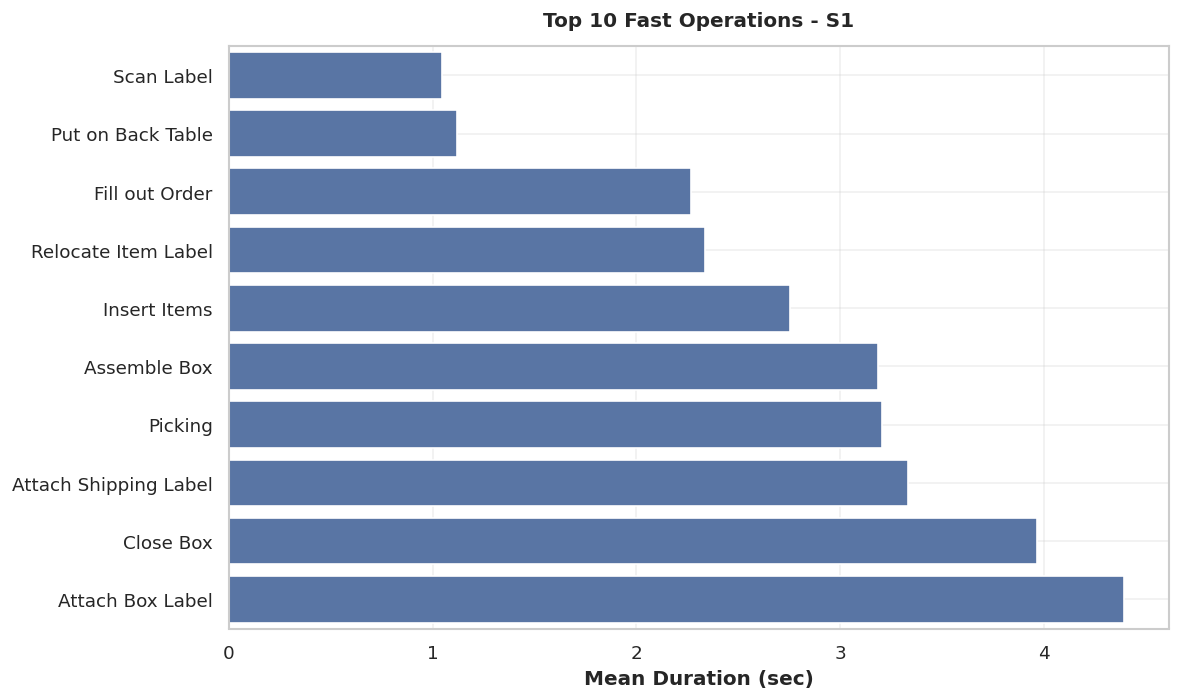

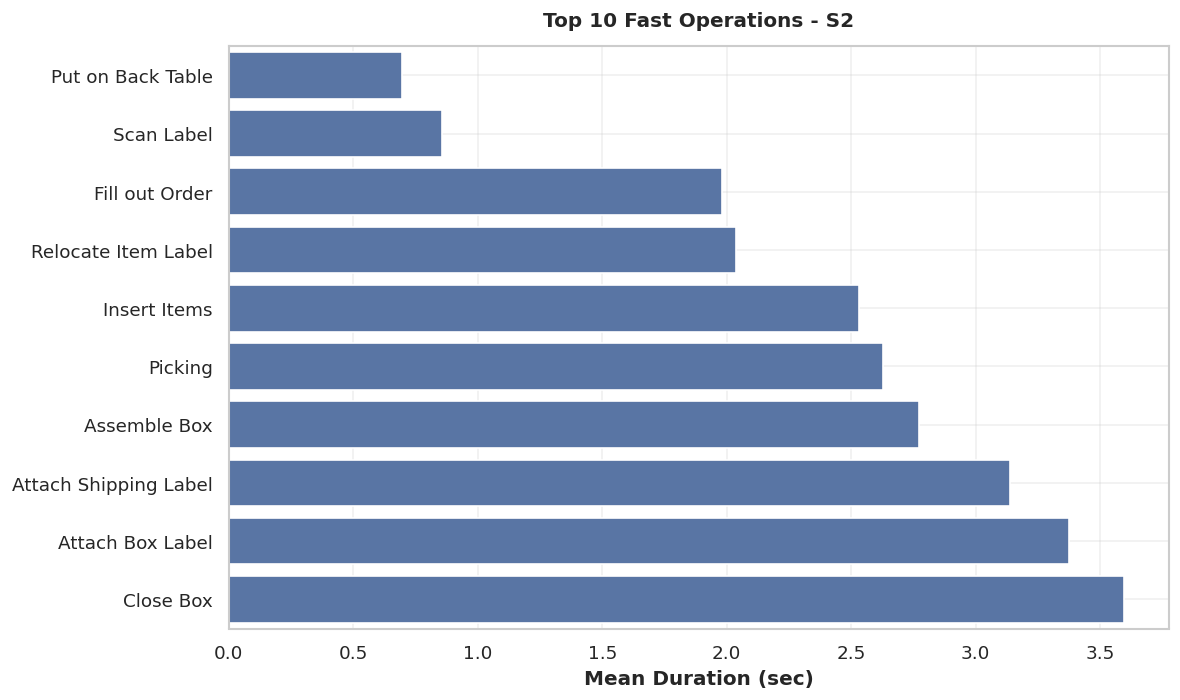

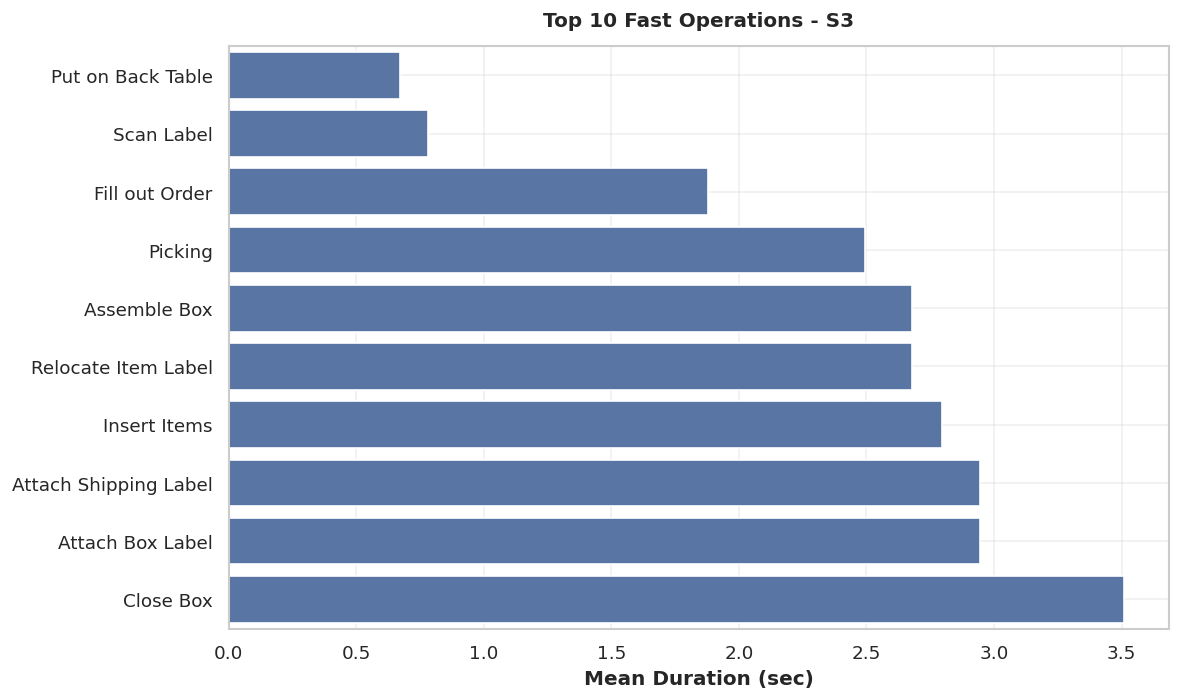

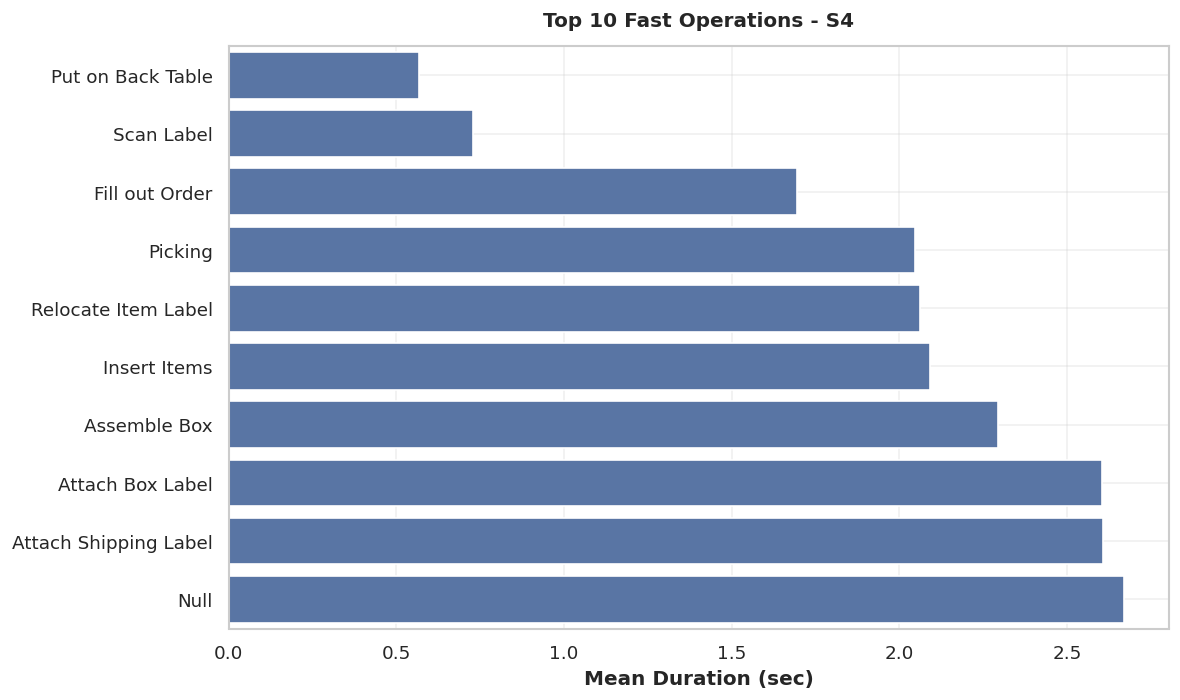

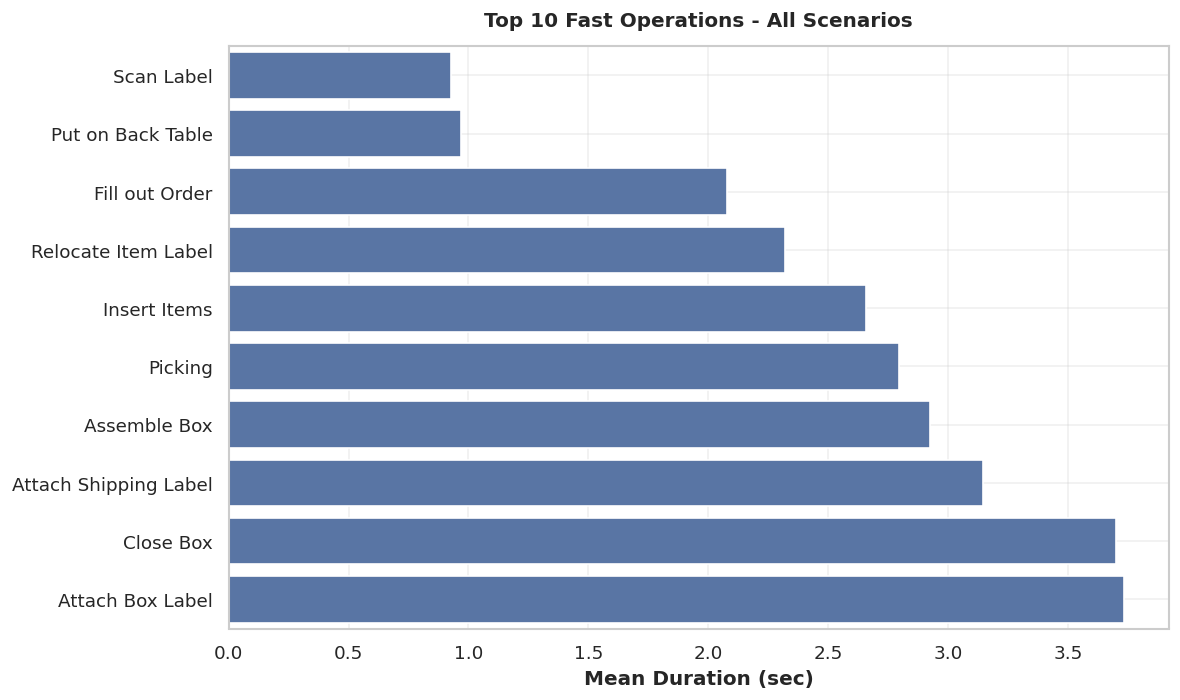

,operation_name,mean_duration,count
10,Scan Label,0.926226,12052
8,Put on Back Table,0.970797,2661
4,Fill out Order,2.080596,6007
9,Relocate Item Label,2.319401,5799
5,Insert Items,2.658951,3579
7,Picking,2.797367,4656
0,Assemble Box,2.925690,7841
2,Attach Shipping Label,3.146467,3980
3,Close Box,3.702304,4023
1,Attach Box Label,3.734749,2010


In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

df = raw_ops.copy()

need_cols = {"Scenario", "operation_name", "duration_sec"}
missing = need_cols - set(df.columns)
if missing:
    raise ValueError(f"raw_ops에 필요한 컬럼이 없습니다: {missing}")

df["duration_sec"] = pd.to_numeric(df["duration_sec"], errors="coerce")
df = df.dropna(subset=["Scenario", "operation_name", "duration_sec"])
df = df[df["duration_sec"] > 0]

def plot_fast_topN(data, title_label, topN=5, min_count=1):
    stats = (
        data.groupby("operation_name")["duration_sec"]
            .agg(mean_duration="mean", count="count")
            .reset_index()
    )

    stats = stats[stats["count"] >= min_count]

    top = stats.sort_values("mean_duration", ascending=True).head(topN)

    plt.figure(figsize=(10, 6))
    sns.barplot(data=top, y="operation_name", x="mean_duration", orient="h")
    plt.title(f"Top {topN} Fast Operations - {title_label}")
    plt.xlabel("Mean Duration (sec)")
    plt.ylabel("")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    return top

for sc in ["S1", "S2", "S3", "S4"]:
    sub = df[df["Scenario"] == sc]
    if sub.empty:
        print(f"[SKIP] {sc} 데이터 없음")
        continue
    plot_fast_topN(sub, title_label=sc, topN=10, min_count=1)

plot_fast_topN(df, title_label="All Scenarios", topN=10, min_count=1)


**Objective 4**

In [23]:
import re
import pandas as pd
import numpy as np

subjects_md_path = "/content/openpack-dataset/docs/data-collection/subjects.md"

rows = []
with open(subjects_md_path, "r", encoding="utf-8") as f:
    for line in f:
        line = line.strip()
        if "|" not in line:
            continue
        if "Subject" in line or "---" in line:
            continue

        parts = [c.strip() for c in line.split("|") if c.strip()]
        if not parts:
            continue
        if not parts[0].startswith("U0"):
            continue
        rows.append(parts[:6])

subjects_df = pd.DataFrame(
    rows,
    columns=["Subject", "Sex", "Age", "DominantHand", "Experience", "Note"]
)

def parse_age(age_str):
    if pd.isna(age_str):
        return np.nan
    m = re.match(r"(\d+)", str(age_str).strip())
    return int(m.group(1)) if m else np.nan

def parse_experience(x):
    if pd.isna(x):
        return np.nan
    s = str(x).strip().lower()
    if s in ["", "-", "none"]:
        return 0

    m1 = re.match(r"(\d+)\s*(month|months|year|years)", s)
    if m1:
        num = int(m1.group(1))
        unit = m1.group(2)
        return num * 12 if "year" in unit else num

    m2 = re.match(r"(\d+)\s*(m|y)", s)
    if m2:
        num = int(m2.group(1))
        unit = m2.group(2)

In [ ]:
# ======================================================
# OpenPack Duration Prediction (Random Forest) - One Cell Final
#  - Fixes: removes stray 'x', makes subjects.md parsing robust
#  - Assumes you already have a DataFrame named `raw_ops`
# ======================================================

import re
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# -------------------------------
# 0) Check required input
# -------------------------------
if "raw_ops" not in globals():
    raise NameError("You must have a DataFrame named `raw_ops` loaded before running this cell.")

subjects_md_path = "/content/openpack-dataset/docs/data-collection/subjects.md"

# -------------------------------
# 1) Read subjects.md -> subjects_df
# -------------------------------
rows = []
with open(subjects_md_path, "r", encoding="utf-8") as f:
    for line in f:
        line = line.strip()
        if "|" not in line:
            continue
        if "Subject" in line or "---" in line:
            continue

        # Split markdown table row: | a | b | c |
        parts = [c.strip() for c in line.split("|")]
        parts = [p for p in parts if p != ""]  # remove empty from leading/trailing pipes

        if not parts:
            continue
        if not str(parts[0]).startswith("U0"):
            continue

        # Keep first 6 columns: Subject, Sex, Age, DominantHand, Experience, Note
        parts = (parts + [None] * 6)[:6]
        rows.append(parts)

subjects_df = pd.DataFrame(
    rows,
    columns=["Subject", "Sex", "Age", "DominantHand", "Experience", "Note"]
)

def parse_age(age_str):
    if pd.isna(age_str):
        return np.nan
    m = re.match(r"(\d+)", str(age_str).strip())
    return int(m.group(1)) if m else np.nan

def parse_experience(exp):
    """
    Returns experience in months.
    Examples:
      "3 months" -> 3
      "2 years"  -> 24
      "2y"       -> 24
      "6m"       -> 6
      "-" / "none" / "" -> 0
      "12" -> 12
    """
    if pd.isna(exp):
        return np.nan
    s = str(exp).strip().lower()

    if s in ["", "-", "none", "nan"]:
        return 0

    # number + unit (month(s)/year(s)/m/y)
    m = re.match(r"^\s*(\d+)\s*(month|months|year|years|m|y)\s*$", s)
    if m:
        num = int(m.group(1))
        unit = m.group(2)
        return num * 12 if unit.startswith("y") or "year" in unit else num

    # just digits
    if s.isdigit():
        return int(s)

    return np.nan

subjects_df["Age_num"] = subjects_df["Age"].apply(parse_age)
subjects_df["Exp_months"] = subjects_df["Experience"].apply(parse_experience)

# -------------------------------
# 2) Prepare raw_ops: duration_sec, operation_name, Scenario
# -------------------------------
ops = raw_ops.copy()

# duration_sec 만들기
if "duration_sec" not in ops.columns:
    if {"start", "end"}.issubset(ops.columns):
        ops["start_dt"] = pd.to_datetime(ops["start"], errors="coerce")
        ops["end_dt"]   = pd.to_datetime(ops["end"], errors="coerce")
        ops["duration_sec"] = (ops["end_dt"] - ops["start_dt"]).dt.total_seconds()
    else:
        raise KeyError("raw_ops must contain either 'duration_sec' or both 'start' and 'end' columns.")

# operation_name 만들기
if "operation_name" not in ops.columns:
    if "operation" in ops.columns:
        ops["operation_name"] = ops["operation"].astype(str)
    else:
        raise KeyError("raw_ops must contain either 'operation_name' or 'operation' column.")

# Scenario 만들기
if "Scenario" not in ops.columns:
    if "Session" in ops.columns:
        ops["Scenario"] = ops["Session"].astype(str).str.extract(r"(S\d)", expand=False)
    else:
        # Scenario가 없으면 그냥 결측으로 두되, 나중에 모델에서 제외될 수 있음
        ops["Scenario"] = np.nan

# -------------------------------
# 3) Clean + merge
# -------------------------------
ops["duration_sec"] = pd.to_numeric(ops["duration_sec"], errors="coerce")
ops = ops.dropna(subset=["duration_sec"])
ops = ops[ops["duration_sec"] > 0]

if "Subject" not in ops.columns:
    raise KeyError("raw_ops must contain 'Subject' column to merge with subjects_df.")

df = ops.merge(subjects_df, on="Subject", how="left")

use_cols = [
    "duration_sec",
    "operation_name",
    "Scenario",
    "Age_num",
    "Exp_months",
    "Sex",
    "DominantHand"
]
df = df[use_cols]

# Age/Exp 없으면 모델 학습 어려우니까 제거
df = df.dropna(subset=["Age_num", "Exp_months"])

print("Modeling Data Shape:", df.shape)
display(df.head())

# -------------------------------
# 4) Train/Test Split
# -------------------------------
X = df.drop("duration_sec", axis=1)
y = df["duration_sec"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# -------------------------------
# 5) Preprocess + Model
# -------------------------------
categorical_cols = [c for c in ["operation_name", "Scenario", "Sex", "DominantHand"] if c in X.columns]
numeric_cols = [c for c in ["Age_num", "Exp_months"] if c in X.columns]

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
        ("num", "passthrough", numeric_cols),
    ],
    remainder="drop"
)

rf = RandomForestRegressor(
    n_estimators=400,
    random_state=42,
    n_jobs=-1
)

model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("rf", rf)
])

# -------------------------------
# 6) Train
# -------------------------------
model.fit(X_train, y_train)

# -------------------------------
# 7) Evaluate
# -------------------------------
y_pred = model.predict(X_test)

mse  = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)

print("\n=== Duration Prediction Performance (Random Forest) ===")
print(f"MSE : {mse:.3f} (sec^2)")
print(f"RMSE: {rmse:.3f} sec")
print(f"MAE : {mae:.3f} sec")
print(f"R²  : {r2:.3f}")

# -------------------------------
# 8) Prediction function
# -------------------------------
def predict_future_duration(
    operation_name: str,
    age: int,
    exp_months: int,
    sex: str = "F",
    dominant_hand: str = "Right",
    scenario: str = "S1",
):
    sample = {
        "operation_name": operation_name,
        "Scenario": scenario,
        "Age_num": age,
        "Exp_months": exp_months,
        "Sex": sex,
        "DominantHand": dominant_hand
    }
    sample_df = pd.DataFrame([sample])
    return float(model.predict(sample_df)[0])

# -------------------------------
# 9) Interactive input
# -------------------------------
print("\n=== Duration Prediction Model (Random Forest) ===")
print("Enter values below.\n")

age = int(input("Age (Age_num) (ex: 30): ").strip())
exp_months = int(input("Experience in months (Exp_months) (ex: 24): ").strip())

sex = input("Sex (M/F) [default F]: ").strip().upper() or "F"
if sex not in ["M", "F"]:
    sex = "F"

dominant_hand = input("Dominant hand (Right/Left) [default Right]: ").strip().title() or "Right"
if dominant_hand not in ["Right", "Left"]:
    dominant_hand = "Right"

scenario = input("Scenario (S1–S4) [default S1]: ").strip().upper() or "S1"
operation_name = input("Operation name (ex: Close Box): ").strip()

pred = predict_future_duration(
    operation_name=operation_name,
    age=age,
    exp_months=exp_months,
    sex=sex,
    dominant_hand=dominant_hand,
    scenario=scenario
)

print(f"\n✅ Predicted task duration: {pred:.2f} seconds")


Modeling Data Shape: (48040, 7)


,duration_sec,operation_name,Scenario,Age_num,Exp_months,Sex,DominantHand
0,1.785,Picking,S1,40.0,10,F,Right
1,2.320,Picking,S1,40.0,10,F,Right
2,1.222,Relocate Item Label,S1,40.0,10,F,Right
3,2.389,Relocate Item Label,S1,40.0,10,F,Right
4,2.174,Assemble Box,S1,40.0,10,F,Right



=== Duration Prediction Performance (Random Forest) ===
MSE : 4.356 (sec^2)
RMSE: 2.087 sec
MAE : 1.342 sec
R²  : 0.197

=== Duration Prediction Model (Random Forest) ===
Enter values below.



In [25]:
import pandas as pd
import numpy as np
import re

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import seaborn as sns
sns.set(style="whitegrid")

from xgboost import XGBRegressor

if "duration_sec" not in raw_ops.columns and {"start", "end"}.issubset(raw_ops.columns):
    raw_ops["start_dt"] = pd.to_datetime(raw_ops["start"], errors="coerce")
    raw_ops["end_dt"]   = pd.to_datetime(raw_ops["end"], errors="coerce")
    raw_ops["duration_sec"] = (raw_ops["end_dt"] - raw_ops["start_dt"]).dt.total_seconds()

if "operation_name" not in raw_ops.columns and "operation" in raw_ops.columns:
    raw_ops["operation_name"] = raw_ops["operation"].astype(str)

if "Scenario" not in raw_ops.columns and "Session" in raw_ops.columns:
    raw_ops["Scenario"] = raw_ops["Session"].str.extract(r"(S\d)").iloc[:, 0]

def parse_age(age_str):
    if pd.isna(age_str):
        return np.nan
    m = re.match(r"(\d+)", str(age_str))
    return int(m.group(1)) if m else np.nan

def parse_experience(exp):
    if pd.isna(exp):
        return np.nan
    s = str(exp).lower().strip()

    if s in ["", "-", "none"]:
        return 0

    m = re.match(r"(\d+)\s*(month|months|year|years|m|y)", s)
    if m:
        num = int(m.group(1))
        unit = m.group(2)
        return num * 12 if unit.startswith("y") else num

    if s.isdigit():
        return int(s)

    return np.nan

subjects_df["Age_num"] = subjects_df["Age"].apply(parse_age)
subjects_df["Exp_months"] = subjects_df["Experience"].apply(parse_experience)

ops_clean = raw_ops.copy()
ops_clean["duration_sec"] = pd.to_numeric(ops_clean["duration_sec"], errors="coerce")
ops_clean = ops_clean.dropna(subset=["duration_sec"])
ops_clean = ops_clean[ops_clean["duration_sec"] > 0]

df = ops_clean.merge(subjects_df, on="Subject", how="left")

use_cols = [
    "duration_sec",
    "operation_name",
    "Scenario",
    "Age_num",
    "Exp_months",
    "Sex",
    "DominantHand"
]

df = df[use_cols].dropna(subset=["Age_num", "Exp_months"])

print("Modeling Data Shape:", df.shape)
print(df.head())

X = df.drop("duration_sec", axis=1)
y = df["duration_sec"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

categorical_cols = [c for c in ["operation_name", "Scenario", "Sex", "DominantHand"] if c in X.columns]
numeric_cols = ["Age_num", "Exp_months"]

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
        ("num", "passthrough", numeric_cols),
    ]
)

xgb = XGBRegressor(
    n_estimators=600,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1
)

model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("xgb", xgb)
])

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse  = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)

print("\n=== Duration Prediction Performance (XGBoost) ===")
print(f"MSE : {mse:.3f} (seconds^2)")
print(f"RMSE: {rmse:.3f} seconds")
print(f"MAE : {mae:.3f} seconds")
print(f"R²  : {r2:.3f}")

def predict_future_duration_xgb(
    operation_name,
    age,
    exp_months,
    sex="F",
    dominant_hand="Right",
    scenario="S1"
):
    sample = {
        "operation_name": operation_name,
        "Scenario": scenario,
        "Age_num": age,
        "Exp_months": exp_months,
        "Sex": sex,
        "DominantHand": dominant_hand
    }
    sample_df = pd.DataFrame([sample])
    return model.predict(sample_df)[0]

print("\n=== Duration Prediction Model (XGBoost) ===")
print("Please enter the values in order.\n")

age = int(input("Age (Age_num) (ex: 30): "))
exp_months = int(input("Experience in months (Exp_months) (ex: 24): "))

sex = input("Sex (M/F): ").strip().upper()
if sex not in ["M", "F"]:
    sex = "F"

dominant_hand = input("Dominant hand (Right/Left): ").strip().title()
if dominant_hand not in ["Right", "Left"]:
    dominant_hand = "Right"

scenario = input("Scenario (S1–S4): ").strip().upper()
operation_name = input("Operation name (ex: Close Box): ").strip()

pred = predict_future_duration_xgb(
    operation_name=operation_name,
    age=age,
    exp_months=exp_months,
    sex=sex,
    dominant_hand=dominant_hand,
    scenario=scenario
)

print(f"\nPredicted task duration: {pred:.2f} seconds")

Modeling Data Shape: (48040, 7)
   duration_sec       operation_name Scenario  Age_num  Exp_months Sex  \
0         1.785              Picking       S1     40.0          10   F   
1         2.320              Picking       S1     40.0          10   F   
2         1.222  Relocate Item Label       S1     40.0          10   F   
3         2.389  Relocate Item Label       S1     40.0          10   F   
4         2.174         Assemble Box       S1     40.0          10   F   

  DominantHand  
0        Right  
1        Right  
2        Right  
3        Right  
4        Right  

=== Duration Prediction Performance (XGBoost) ===
MSE : 4.348 (seconds^2)
RMSE: 2.085 seconds
MAE : 1.341 seconds
R²  : 0.199

=== Duration Prediction Model (XGBoost) ===
Please enter the values in order.



KeyboardInterrupt: Interrupted by user

In [ ]:
import pandas as pd
import numpy as np
import re

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import seaborn as sns
sns.set(style="whitegrid")

if "duration_sec" not in raw_ops.columns and {"start", "end"}.issubset(raw_ops.columns):
    raw_ops["start_dt"] = pd.to_datetime(raw_ops["start"], errors="coerce")
    raw_ops["end_dt"]   = pd.to_datetime(raw_ops["end"], errors="coerce")
    raw_ops["duration_sec"] = (raw_ops["end_dt"] - raw_ops["start_dt"]).dt.total_seconds()

if "operation_name" not in raw_ops.columns and "operation" in raw_ops.columns:
    raw_ops["operation_name"] = raw_ops["operation"].astype(str)

if "Scenario" not in raw_ops.columns and "Session" in raw_ops.columns:
    raw_ops["Scenario"] = raw_ops["Session"].str.extract(r"(S\d)").iloc[:, 0]

def parse_age(age_str):
    if pd.isna(age_str):
        return np.nan
    m = re.match(r"(\d+)", str(age_str))
    return int(m.group(1)) if m else np.nan

def parse_experience(exp):
    if pd.isna(exp):
        return np.nan
    s = str(exp).lower().strip()

    if s in ["", "-", "none"]:
        return 0

    m = re.match(r"(\d+)\s*(month|months|year|years|m|y)", s)
    if m:
        num = int(m.group(1))
        unit = m.group(2)
        return num * 12 if unit.startswith("y") else num

    if s.isdigit():
        return int(s)

    return np.nan

subjects_df["Age_num"] = subjects_df["Age"].apply(parse_age)
subjects_df["Exp_months"] = subjects_df["Experience"].apply(parse_experience)

ops_clean = raw_ops.copy()
ops_clean["duration_sec"] = pd.to_numeric(ops_clean["duration_sec"], errors="coerce")
ops_clean = ops_clean.dropna(subset=["duration_sec"])
ops_clean = ops_clean[ops_clean["duration_sec"] > 0]

df = ops_clean.merge(subjects_df, on="Subject", how="left")

use_cols = [
    "duration_sec",
    "operation_name",
    "Scenario",
    "Age_num",
    "Exp_months",
    "Sex",
    "DominantHand"
]

df = df[use_cols].dropna(subset=["Age_num", "Exp_months"])

print("Modeling Data Shape:", df.shape)
print(df.head())

X = df.drop("duration_sec", axis=1)
y = df["duration_sec"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

categorical_cols = [c for c in ["operation_name", "Scenario", "Sex", "DominantHand"] if c in X.columns]
numeric_cols = ["Age_num", "Exp_months"]

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
        ("num", "passthrough", numeric_cols),
    ]
)

lin = LinearRegression()

model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("linreg", lin)
])

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse  = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)

print("\n=== Duration Prediction Performance (Linear Regression) ===")
print(f"MSE : {mse:.3f} (seconds^2)")
print(f"RMSE: {rmse:.3f} seconds")
print(f"MAE : {mae:.3f} seconds")
print(f"R²  : {r2:.3f}")

def predict_future_duration_lin(
    operation_name,
    age,
    exp_months,
    sex="F",
    dominant_hand="Right",
    scenario="S1"
):
    sample = {
        "operation_name": operation_name,
        "Scenario": scenario,
        "Age_num": age,
        "Exp_months": exp_months,
        "Sex": sex,
        "DominantHand": dominant_hand
    }
    sample_df = pd.DataFrame([sample])
    pred = model.predict(sample_df)[0]
    pred = max(pred, 0)  # ✅ prevent negative durations
    return pred

print("\n=== Duration Prediction Model (Linear Regression) ===")
print("Please enter the values in order.\n")

age = int(input("Age (Age_num) (ex: 30): "))
exp_months = int(input("Experience in months (Exp_months) (ex: 24): "))

sex = input("Sex (M/F): ").strip().upper()
if sex not in ["M", "F"]:
    sex = "F"

dominant_hand = input("Dominant hand (Right/Left): ").strip().title()
if dominant_hand not in ["Right", "Left"]:
    dominant_hand = "Right"

scenario = input("Scenario (S1–S4): ").strip().upper()
operation_name = input("Operation name (ex: Close Box): ").strip()

pred = predict_future_duration_lin(
    operation_name=operation_name,
    age=age,
    exp_months=exp_months,
    sex=sex,
    dominant_hand=dominant_hand,
    scenario=scenario
)

print(f"\nPredicted task duration: {pred:.2f} seconds")